[Title - Edit?]
# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

[Introduction] + theory 

[Code Intro/Algo] explaination

In [103]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
# Inline Plots

%matplotlib inline

In [5]:
# """ 
# Function to calculate distance between 2 points
# Needs the points in form of numpy array, returns the scalar distance
# """

# def EucDist2D(x1,x2):
#     dist=np.linalg.norm(x1-x2)
#     return dist

In [6]:
# nSeeds= 1000  # Seeds to start tesselation
# N = 100 # Square Domain size
# N2D=N**N
# x=np.linspace(0,N,N)
# y=np.linspace(0,N,N)
# seedCoord=np.zeros([nSeeds,2])
# for i in range(0, nSeeds):
#     seedCoord[i,0] = random.randint(0, N)
#     seedCoord[i,1] = random.randint(0, N)

In [7]:
# dist=np.zeros([nSeeds,1])
# grainID=np.zeros([N,N])
# for i in range(0,N):
#     for j in range(0,N):
#         minDist=float("inf")
#         for k in range(0,nSeeds):
#             dist[k]=EucDist2D(seedCoord[k],np.array([x[i],y[j]]))
#         grainID[i,j]=np.argmin(dist)

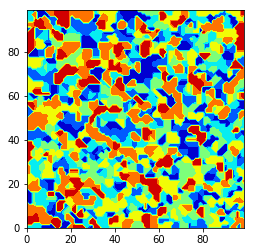

In [8]:
# plt.contourf(grainID,cmap=cm.jet)
# plt.gca().set_aspect('equal', adjustable='box')

Make a 2D square lattice:

In [225]:
nlp=10 # number of lattice points
N=(nlp+1)*(nlp+1)
Q=32 #Number of states in Q-state potts model
X=np.linspace(0,1,nlp+1)
x,y = np.meshgrid(X,X)

Random Initial State Matrix:

In [222]:
state=np.random.randint(Q, size=(x.shape))
colormatrix=np.random.rand(Q,3)

**MCS Loop Starts here:**

In [81]:
# Boundary detection
isinside=np.ones(shape=(x.shape))
for i in range(0,nlp+1):
    for j in range(0,nlp+1):
        if (i==0) or (j==0) or (i==nlp) or (j==nlp):
            isinside[i][j]=0
            
        

print(isinside)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [224]:
state

array([[ 5,  8, 31, 11, 28, 14, 18, 23,  2, 30, 29],
       [ 2,  9, 15,  6, 29,  4, 23, 21,  4, 16,  6],
       [22,  9,  6, 19,  7,  7,  0, 28,  2, 25, 21],
       [ 1, 30,  2, 12, 11, 11, 28, 28, 23, 10,  8],
       [27, 21, 22, 18, 11,  3,  1, 10, 24,  0, 27],
       [26, 17, 23, 30, 17, 30, 31, 21,  8,  2, 14],
       [16, 15, 30, 23, 28, 13, 12, 17, 17,  7, 12],
       [ 6, 19, 15, 26, 14, 14, 19, 21, 19, 24, 29],
       [26, 31,  5, 19, 26,  8, 23, 19, 15, 18, 29],
       [ 5, 26, 28, 23, 28,  3,  0, 20, 28, 10, 26],
       [ 0, 22, 12, 30,  3,  2,  5, 23, 28, 30, 31]])

In [ ]:
for i in range(0,N):
    # Pick random lattice cite
    i=np.random.randint(len(x))
    j=np.random.randint(len(x))
    
    

In [218]:
# Plotting as squares

# fig,ax=plt.subplots(1)
# for i in range(0,nlp+1):
#     for j in range(0,nlp+1):
#         rect = patches.Rectangle((x[i,j],y[i,j]),1.0/nlp,1.0/nlp,linewidth=1,edgecolor='none',facecolor=colormatrix[state[i,j],:])
#         ax.add_patch(rect)

# plt.gca().set_aspect('equal', adjustable='box')
